In [1]:
import sympy

In [2]:
import helper_functions as hf

In [3]:
sympy.init_printing(use_unicode=True)

dt = sympy.Symbol("\Delta t", real=True)
g = sympy.Symbol("g", real=True)

**Integrated gyroscope measurements**

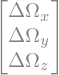

In [4]:
delta_angle_x = sympy.Symbol("\Delta \Omega_x", real=True)
delta_angle_y = sympy.Symbol("\Delta \Omega_y", real=True)
delta_angle_z = sympy.Symbol("\Delta \Omega_z", real=True)
delta_angle = sympy.Matrix([delta_angle_x, delta_angle_y, delta_angle_z])
delta_angle

**Integrated accelerometer measurements**

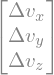

In [5]:
delta_velocity_x = sympy.Symbol("\Delta v_x", real=True)
delta_velocity_y = sympy.Symbol("\Delta v_y", real=True)
delta_velocity_z = sympy.Symbol("\Delta v_z", real=True)
delta_velocity = sympy.Matrix([delta_velocity_x, delta_velocity_y, delta_velocity_z])
delta_velocity

**Combined IMU measurements**

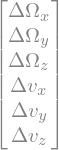

In [6]:
u = sympy.Matrix([delta_angle, delta_velocity])
u

**Gyroscope noise variance**

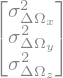

In [7]:
delta_angle_x_var = sympy.Symbol("\sigma^2_{\Delta \Omega_x}", real=True)
delta_angle_y_var = sympy.Symbol("\sigma^2_{\Delta \Omega_y}", real=True)
delta_angle_z_var = sympy.Symbol("\sigma^2_{\Delta \Omega_z}", real=True)
delta_angle_var = sympy.Matrix([delta_angle_x_var, delta_angle_y_var, delta_angle_z_var])
delta_angle_var

**Accelerometer noise variance**

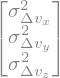

In [8]:
delta_velocity_x_var = sympy.Symbol("\sigma^2_{\Delta v_x}", real=True)
delta_velocity_y_var = sympy.Symbol("\sigma^2_{\Delta v_y}", real=True)
delta_velocity_z_var = sympy.Symbol("\sigma^2_{\Delta v_z}", real=True)
delta_velocity_var = sympy.Matrix([delta_velocity_x_var, delta_velocity_y_var, delta_velocity_z_var])
delta_velocity_var

**Combined IMU noise variance**

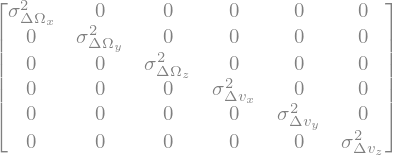

In [9]:
u_var = sympy.Matrix.diag(delta_angle_x_var, delta_angle_y_var, delta_angle_z_var, delta_velocity_x_var, delta_velocity_y_var, delta_velocity_z_var)
u_var

## Definition of state vector
### orientation
Using w-x-y-z convention

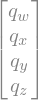

In [10]:
qw = sympy.Symbol("q_w", real=True)
qx = sympy.Symbol("q_x", real=True)
qy = sympy.Symbol("q_y", real=True)
qz = sympy.Symbol("q_z", real=True)
q = sympy.Matrix([qw, qx, qy, qz])
q

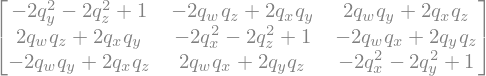

In [11]:
R_to_earth = hf.quat2Rot(q)
R_to_body = R_to_earth.T
R_to_earth

### velocity
Using the map (ENU) reference frame, following the ROS convention.

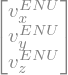

In [12]:
vx = sympy.Symbol("v^{ENU}_x", real=True)
vy = sympy.Symbol("v^{ENU}_y", real=True)
vz = sympy.Symbol("v^{ENU}_z", real=True)
v = sympy.Matrix([vx, vy, vz])
v

### Position
Using the map (ENU) reference frame, following the ROS convention.

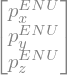

In [13]:
px = sympy.Symbol("p^{ENU}_x", real=True)
py = sympy.Symbol("p^{ENU}_y", real=True)
pz = sympy.Symbol("p^{ENU}_z", real=True)
p = sympy.Matrix([px, py, pz])
p

### Delta angle bias

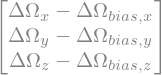

In [14]:
delta_angle_bias_x = sympy.Symbol("\Delta \Omega_{bias,x}", real=True)
delta_angle_bias_y = sympy.Symbol("\Delta \Omega_{bias,y}", real=True)
delta_angle_bias_z = sympy.Symbol("\Delta \Omega_{bias,z}", real=True)
delta_angle_bias = sympy.Matrix([delta_angle_bias_x, delta_angle_bias_y, delta_angle_bias_z])
delta_angle_true = delta_angle - delta_angle_bias
delta_angle_true

### Delta velocity bias

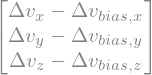

In [15]:
delta_velocity_bias_x = sympy.Symbol("\Delta v_{bias, x}", real=True)
delta_velocity_bias_y = sympy.Symbol("\Delta v_{bias, y}", real=True)
delta_velocity_bias_z = sympy.Symbol("\Delta v_{bias, z}", real=True)
delta_velocity_bias = sympy.Matrix([delta_velocity_bias_x, delta_velocity_bias_y, delta_velocity_bias_z])
delta_velocity_true = delta_velocity - delta_velocity_bias
delta_velocity_true

### State vector

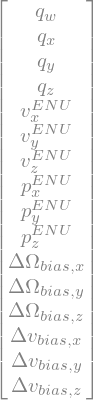

In [16]:
state = sympy.Matrix([q, v, p, delta_angle_bias, delta_velocity_bias])
state

## State propagation/prediction
### Orientation

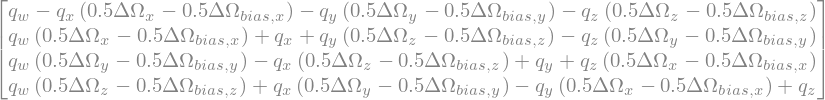

In [17]:
q_new = hf.quat_mult(q, sympy.Matrix([1, 0.5 * delta_angle_true[0], 0.5 * delta_angle_true[1], 0.5 * delta_angle_true[2]]))
q_new

### Velocity
subtract gravity vector (not sure about sign)

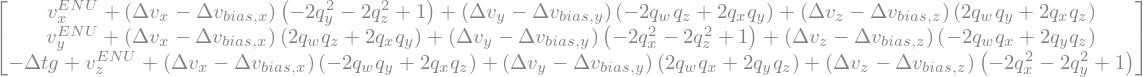

In [18]:
v_new = v + R_to_earth * delta_velocity_true + sympy.Matrix([0, 0, -g]) * dt
v_new

### Position

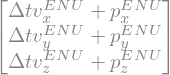

In [19]:
p_new = p + v * dt
p_new

### IMU bias

In [20]:
delta_angle_bias_new = delta_angle_bias
delta_velocity_bias_new = delta_velocity_bias

### State

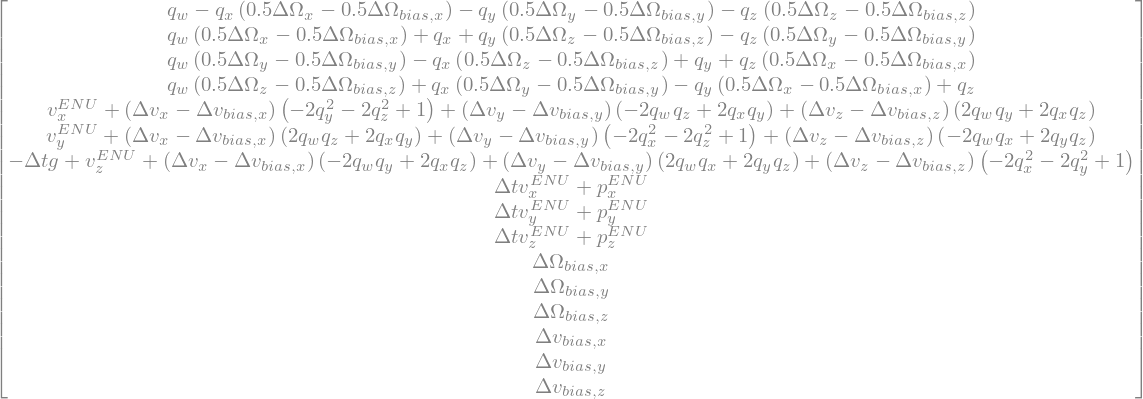

In [21]:
state_new = sympy.Matrix([q_new, v_new, p_new, delta_angle_bias_new, delta_velocity_bias_new])
state_new

## State propagation/prediction jacobians

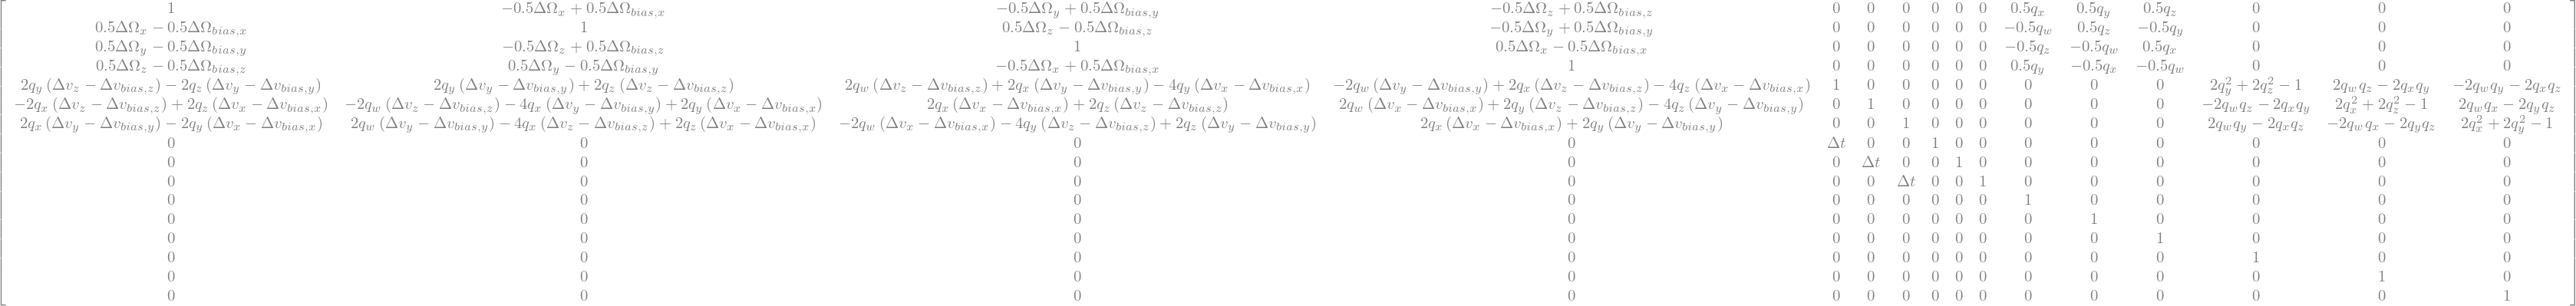

In [22]:
F = state_new.jacobian(state)
F

### Process Noise

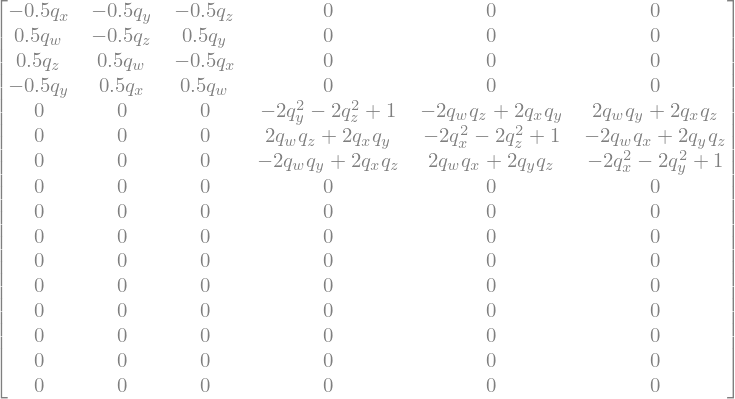

In [23]:
G = state_new.jacobian(u)
G

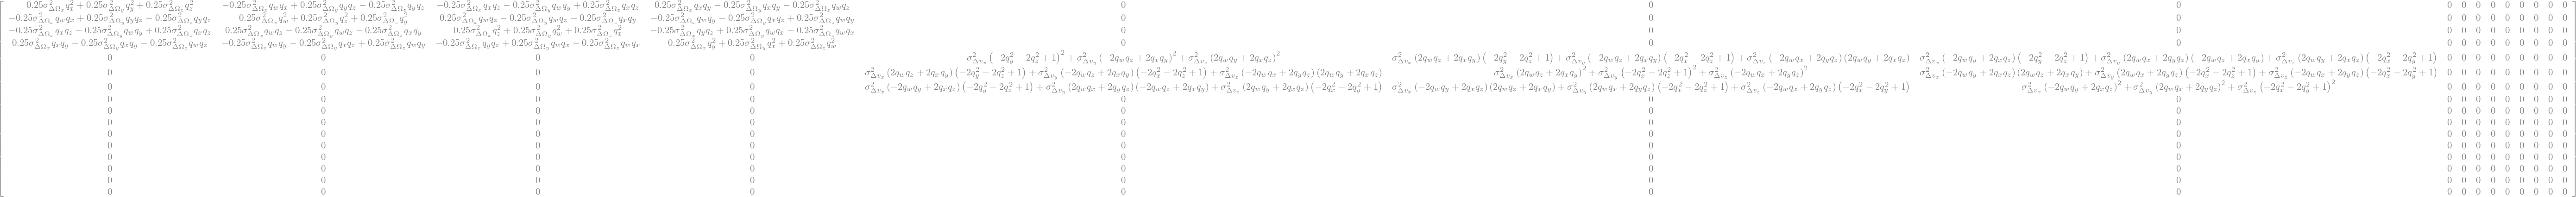

In [24]:
Q = G * u_var * G.T
Q

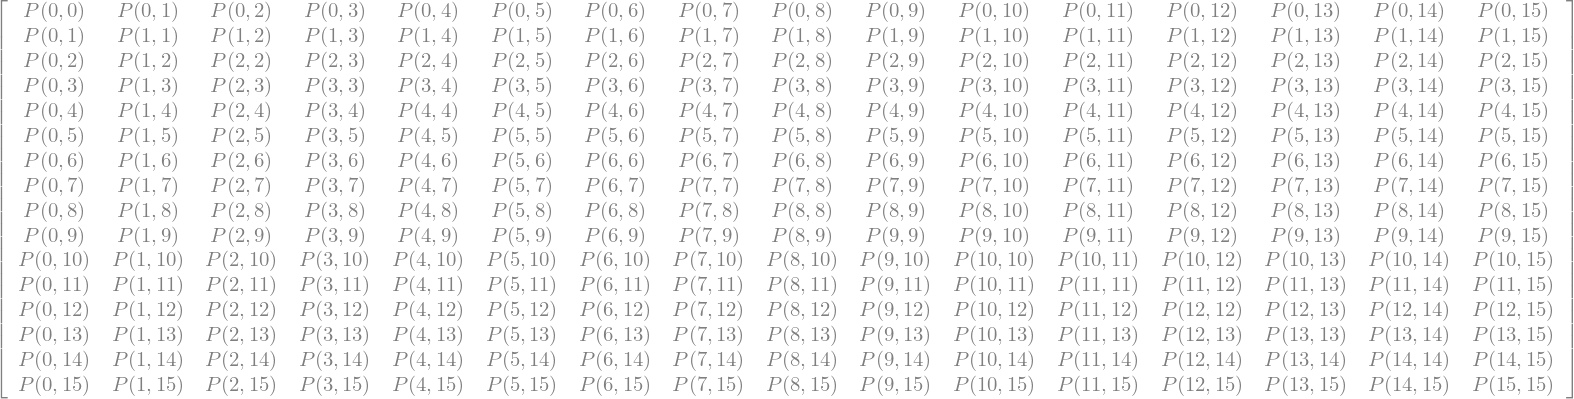

In [25]:
P = hf.create_symmetric_cov_matrix([sympy.shape(state)[0], sympy.shape(state)[0]])
P

In [ ]:
P_new = F * P * F.T + Q
for row in range(sympy.shape(P_new)[0]):
    for col in range(sympy.shape(P_new)[1]):
        if row > col:
            P_new[row, col] = 0
P_new

⎡                                                                             
⎢P(0,0) + P(0,1)⋅(-0.5⋅\Delta \Omegaₓ + 0.5⋅\Delta \Omega_{bias,x}) + 0.5⋅P(0,
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

In [ ]:
P_new_simple = sympy.cse(P_new, sympy.utilities.iterables.numbered_symbols(prefix='PS'), optimizations='basic')

P_new_simple